In [1]:
import sys
import os
import json

from astropy.io import fits
from pprint import pprint
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams['axes.grid'] = False
matplotlib.rcParams['image.origin'] = 'lower'
import numpy as np
from astropy.wcs import WCS
from astropy.table import Table
import astropy.wcs.utils

In [2]:
# the first pandeia import is required to run calculations. the others are provided to allow setting up calculations and loading/saving of inputs or results.
from pandeia.engine.perform_calculation import perform_calculation
from pandeia.engine.calc_utils import get_telescope_config, get_instrument_config, build_default_calc, build_default_source
from pandeia.engine.io_utils import read_json, write_json

In [3]:
# TODO get header so I can pull info from header to compute pixel values in arcsecs

In [4]:
fits_file = 'output.fits'

header = fits.getheader(fits_file)
model = fits.getdata(fits_file)

print(model.shape)

(45, 45)


In [5]:
pprint(header)

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  


In [6]:
test_model = np.ones((45, 45))

In [7]:
# pprint(model)

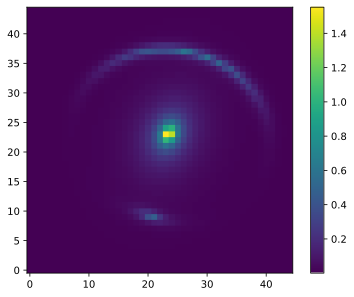

In [8]:
plt.imshow(model)
plt.colorbar()

In [9]:
calc = build_default_calc('roman','wfi','imaging')

In [10]:
# don't allow scene size to change
calc['configuration']['dynamic_scene'] = True
calc['configuration']['max_scene_size'] = 5

In [11]:
# change filter
calc['configuration']['instrument']['filter'] = 'f106'

In [12]:
# normalize (np.interp for now)
max = np.max(model)
min = np.min(model)

model = np.interp(model, (min, max), (0.00001, 0.001))
# model = np.reciprocal(model)

In [13]:
# pprint(model)

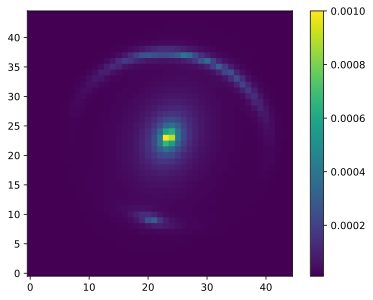

In [14]:
plt.imshow(model)
plt.colorbar()

In [15]:
# calculate arcsec value of bottom-right corner
offset = (45 / 2) * 0.11

In [16]:
def pixel_to_arcsec(pixel_value):
    return pixel_value * 0.11

In [17]:
i = 0

for row_number, row in tqdm(enumerate(model)):
    for item_number, item in enumerate(row):
        if i != 0:
            calc['scene'].append(build_default_source(geometry="point"))
        calc['scene'][i]['position']['x_offset'] = pixel_to_arcsec(item_number) - offset # arcsec
        calc['scene'][i]['position']['y_offset'] = pixel_to_arcsec(row_number) - offset # arcsec
        calc['scene'][i]['spectrum']['normalization']['norm_flux'] = item

        i += 1

45it [00:11,  4.05it/s]


In [18]:
pprint(calc)

{'background': 'minzodi',
 'background_level': 'benchmark',
 'calculation': {'effects': {'saturation': None},
                 'noise': {'crs': None, 'ffnoise': None, 'scatter': None}},
 'configuration': {'detector': {'nexp': 1,
                                'ngroup': 10,
                                'nint': 1,
                                'readout_pattern': 'deep2',
                                'subarray': 'imaging'},
                   'dynamic_scene': True,
                   'instrument': {'aperture': 'imaging',
                                  'disperser': None,
                                  'filter': 'f106',
                                  'instrument': 'wfi',
                                  'mode': 'imaging'},
                   'max_scene_size': 5,
                   'scene_size': 5},
 'scene': [{'position': {'orientation': 0.0,
                         'position_parameters': ['x_offset',
                                                 'y_offset',
         

In [19]:
results = perform_calculation(calc)

detector = results['2d']['detector']

print(detector.shape)

(45, 45)


In [20]:
pprint(results)

{'1d': {'bg': [array([0.885     , 0.88512801, 0.88956473, 0.88999999, 0.89402369,
       0.898505  , 0.89999998, 0.90300878, 0.90753513, 0.90999997,
       0.91208417, 0.91665601, 0.91999996, 0.92125076, 0.92586855,
       0.92899996, 0.93050949, 0.93517369, 0.93986126, 0.94      ,
       0.94457234, 0.94930703, 0.94999999, 0.95406545, 0.95884772,
       0.95999998, 0.96365397, 0.9684843 , 0.96999997, 0.97333885,
       0.97821773, 0.97999996, 0.98312107, 0.98804898, 0.98999995,
       0.9930016 , 0.99797904, 1.        , 1.00298143, 1.0080089 ,
       1.00999999, 1.01306156, 1.01813955, 1.01999998, 1.023243  ,
       1.02837203, 1.02999997, 1.03352676, 1.03870734, 1.03999996,
       1.04391388, 1.04914652, 1.04999995, 1.05440539, 1.05969062,
       1.05999982, 1.06500234, 1.06900001, 1.07034068, 1.07570579,
       1.07999992, 1.08109779, 1.08651681, 1.08899999, 1.091963  ,
       1.09743649, 1.10000002, 1.10293741, 1.10846591, 1.10899997,
       1.11402212, 1.11960618, 1.12      , 1.12

In [21]:
# TODO TEMP! flip image
detector = np.flipud(detector)
# detector = np.fliplr(detector)

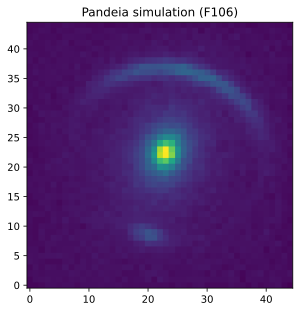

In [22]:
plt.imshow(detector)
plt.title('Pandeia simulation (F106)')
# plt.colorbar()
plt.savefig('figures/pandeia.png')

In [23]:
# save this numpy array
np.save('detector', detector)